In [1]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import geoutils as gu
import xdem
from pprint import pprint
import altair as alt
from rasterio.enums import Resampling
import json 
import seaborn as sns

## Inputs

If you use the arg, you must run from CLI like this

```
HSFM_GEOMORPH_INPUT_FILE='inputs/mazama_inputs.json' jupyter nbconvert --execute --to html dem-analysis/mt_baker_mass_wasted/xdem.ipynb  --output outputs/xdem_mazama.html
```

In [2]:
# json_file_path = 'inputs/mazama_inputs.json'
# Or set an env arg:
if os.environ.get('HSFM_GEOMORPH_INPUT_FILE'):
    json_file_path = os.environ['HSFM_GEOMORPH_INPUT_FILE']

In [3]:
with open(json_file_path, 'r') as j:
     params = json.loads(j.read())

In [4]:
params

{'inputs': {'valley_name': 'Mazama',
  'TO_DROP': ['1947_09_14',
   '1970_09_09',
   '1974_08_10',
   '1987_08_21',
   '1990_09_05',
   '1991_09_09',
   '1992_09_15'],
  'TO_DROP_LARGER_AREA': ['1947_09_14',
   '1970_09_09',
   '1970_09_29',
   '1977_09_27',
   '1992_09_18',
   '1974_08_10',
   '1987_08_21',
   '1990_09_05',
   '1991_09_09',
   '1992_09_15'],
  'erosion_polygon_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/erosion.geojson',
  'erosion_by_date_polygon_file': None,
  'glacier_polygons_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/glaciers.geojson',
  'dems_path': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems',
  'valley_bounds_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/valley_bounds.geojson',
  'plot_output_dir': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/plots/',
  'uncertainty_file': 'outputs/uncertainty_mazama.pcl',
  'uncertainty_file_largearea': 

In [5]:
# Read inputs from params
valley_name = params['inputs']['valley_name']
TO_DROP = params['inputs']['TO_DROP']
TO_DROP_LARGER_AREA = params['inputs']['TO_DROP_LARGER_AREA']
TO_COREGISTER = params['inputs']['TO_COREGISTER']
SAVE_DDEMS = params['inputs']['SAVE_DDEMS']
EROSION_BY_DATE = params['inputs']['EROSION_BY_DATE']
INTERPOLATE = params['inputs']['INTERPOLATE']
FILTER_OUTLIERS = params['inputs']['FILTER_OUTLIERS']
glacier_polygons_file = params['inputs']['glacier_polygons_file']
dems_path = params['inputs']['dems_path']
valley_bounds_file = params['inputs']['valley_bounds_file']
strip_time_format = params['inputs']['strip_time_format']
plot_output_dir = params['inputs']['plot_output_dir']
uncertainty_file = params['inputs']['uncertainty_file']
uncertainty_file_largerarea = params["inputs"]["uncertainty_file_largearea"]
measurement_threshold = params['inputs']['measurement_threshold']
SIMPLE_FILTER = params['inputs']['SIMPLE_FILTER']
simple_filter_threshold = params['inputs']['simple_filter_threshold']

plot_figsize = params['inputs']['plot_figsize']
plot_vmin = params['inputs']['plot_vmin']
plot_vmax = params['inputs']['plot_vmax']
MASK_GLACIER_SIGNALS = params['inputs']['MASK_GLACIER_SIGNALS']
MASK_EXTRA_SIGNALS = params['inputs']['MASK_EXTRA_SIGNALS']
RUN_LARGER_AREA = params["inputs"]['RUN_LARGER_AREA']

interpolation_max_search_distance = params['inputs']['interpolation_max_search_distance']

if EROSION_BY_DATE:
    erosion_polygon_file = params['inputs']['erosion_by_date_polygon_file']
else:
    erosion_polygon_file = params['inputs']['erosion_polygon_file']

# Read output inputs from params
erosion_polygons_cropped_by_glaciers_output_file = params['outputs']['erosion_polygons_cropped_by_glaciers_output_file']
dods_output_path = params['outputs']['dods_output_path']

reference_dem_date = datetime.strptime(
    params['inputs']['reference_dem_date'], 
    strip_time_format
)

In [6]:
if RUN_LARGER_AREA:
    uncertainty_df = pd.read_pickle(uncertainty_file_largerarea)
else:
    uncertainty_df = pd.read_pickle(uncertainty_file)
uncertainty_df.head()

Range      Sill                  Interval      NMAD      Mean  \
0  115.222367  0.210968  (1970-09-29, 1977-09-27]  0.951148 -0.247167   
1   70.745691  0.334636  (1977-09-27, 1979-10-06]  0.669541  0.299675   
2   88.280867  0.402075  (1979-10-06, 1992-09-18]  0.452997 -0.290949   
3   54.111937  0.313693  (1992-09-18, 2013-09-13]  0.418539  0.232574   
4   46.324128  0.171242  (2013-09-13, 2015-09-01]  0.323307 -0.038412   

     Median      RMSE    StdDev        Max        Min Count of stable pixels  \
0  -0.12439  0.974601  0.942738   5.938354   -5.81189                  11732   
1  0.325562  0.878594  0.825907   6.616089  -5.711792                  11574   
2 -0.270874  0.766900  0.709567  15.994385 -19.338623                   9574   
3  0.213274  0.685471   0.64481  18.507508  -7.948212                   9902   
4 -0.026474  0.491127  0.489622   7.379007  -6.548724                  13349   

  Count of all pixels Outlier lower limit Outlier upper limit  \
0              214628                 -20                  20   
1              244291                 -20                  20   
2              237819                 -20                  20   
3              297554                 -20                  20   
4             1079764                 -20                  20   

                                          pre-filter  \
0  {'NMAD': 0.9511479858398437, 'Mean': -0.247166...   
1  {'NMAD': 0.6695408569335937, 'Mean': 0.2996750...   
2  {'NMAD': 0.45390146484375, 'Mean': -0.41155689...   
3  {'NMAD': 0.4195985536502239, 'Mean': 0.3492803...   
4  {'NMAD': 0.32330682186868476, 'Mean': -0.03841...   

  Percentage all pixels filtered/removed  \
0                               0.042916   
1                               0.001553   
2                                0.04101   
3                               0.033596   
4                               0.045531   

  Percentage stable pixels filtered/removed Start Date   End Date  
0                                       0.0 1970-09-29 1977-09-27  
1                                       0.0 1977-09-27 1979-10-06  
2                                  0.001981 1979-10-06 1992-09-18  
3                                  0.001915 1992-09-18 2013-09-13  
4                                       0.0 2013-09-13 2015-09-01

In [7]:
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir, exist_ok=True)

## Get DEM file paths

In [8]:
dem_fn_list = glob.glob(os.path.join(dems_path, "*.tif"))
dem_fn_list = sorted(dem_fn_list)

if RUN_LARGER_AREA:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP_LARGER_AREA]
else:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/1970_09_29.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/1977_09_27.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/1979_10_06.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/1992_09_18.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/2013_09_13.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/2015_09_01.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/2019_10_11.tif']

In [9]:
datetimes = [datetime.strptime(Path(f).stem, strip_time_format) for f in dem_fn_list]
datetimes

[datetime.datetime(1970, 9, 29, 0, 0),
 datetime.datetime(1977, 9, 27, 0, 0),
 datetime.datetime(1979, 10, 6, 0, 0),
 datetime.datetime(1992, 9, 18, 0, 0),
 datetime.datetime(2013, 9, 13, 0, 0),
 datetime.datetime(2015, 9, 1, 0, 0),
 datetime.datetime(2019, 10, 11, 0, 0)]

## Open valley bounds polygons

In [10]:
valley_bounds = gu.Vector(valley_bounds_file)
if RUN_LARGER_AREA:
    valley_bounds_vect = valley_bounds.query(f"name == '{valley_name}' and purpose=='analysis large'")
else:
    valley_bounds_vect = valley_bounds.query(f"name == '{valley_name}' and purpose=='analysis'")

## Create DEMCollection

In [11]:
demcollection = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    valley_bounds_vect, 
    2,
    resampling = Resampling.cubic
)

## Open glacier polygons

In [12]:
glaciers_gdf = gpd.read_file(glacier_polygons_file).to_crs(demcollection.reference_dem.crs)
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: datetime.strptime(x, strip_time_format))

## Plot DEMs

/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


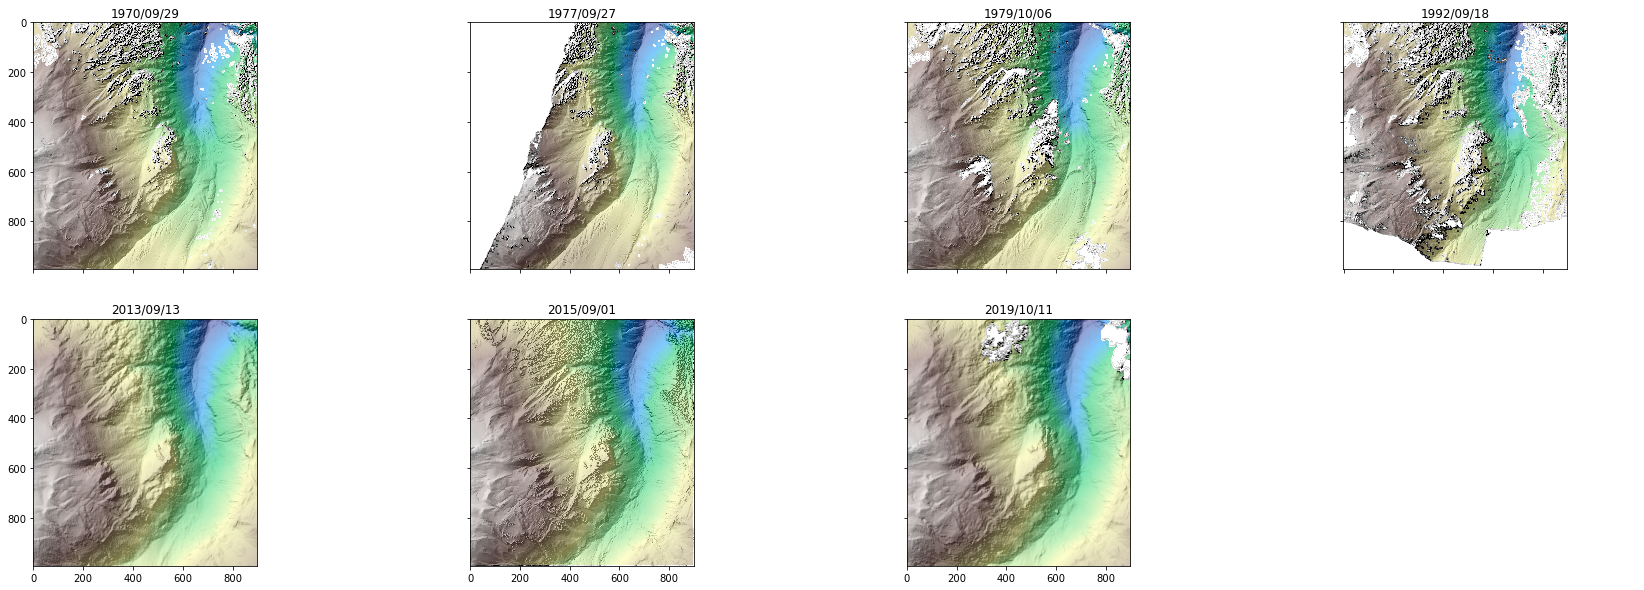

In [13]:
fig, axes = demcollection.plot_dems(hillshade=True, interpolation = "none", figsize=plot_figsize)
fig.savefig(os.path.join(plot_output_dir, "dem_gallery.png"))
plt.show()

## Coregister DEMs or Do Not

In [14]:

if TO_COREGISTER:
    for i in range(0, len(demcollection.dems)-1):
        early_dem = demcollection.dems[i]
        late_dem = demcollection.dems[i+1]

        nuth_kaab = xdem.coreg.NuthKaab()
        # Order with the future as reference
        nuth_kaab.fit(late_dem.data, early_dem.data, transform=late_dem.transform)

        # Apply the transformation to the data (or any other data)
        aligned_ex = nuth_kaab.apply(early_dem.data, transform=early_dem.transform)

        print(F"For DEM {early_dem.datetime}, transform is {nuth_kaab.to_matrix()}")

        early_dem.data = np.expand_dims(aligned_ex, axis=0)

## Subtract DEMs/Create DoDs

In [15]:
_ = demcollection.subtract_dems_intervalwise()
# _ = demcollection_large.subtract_dems_intervalwise()

## Plot DoDs (pre processing)

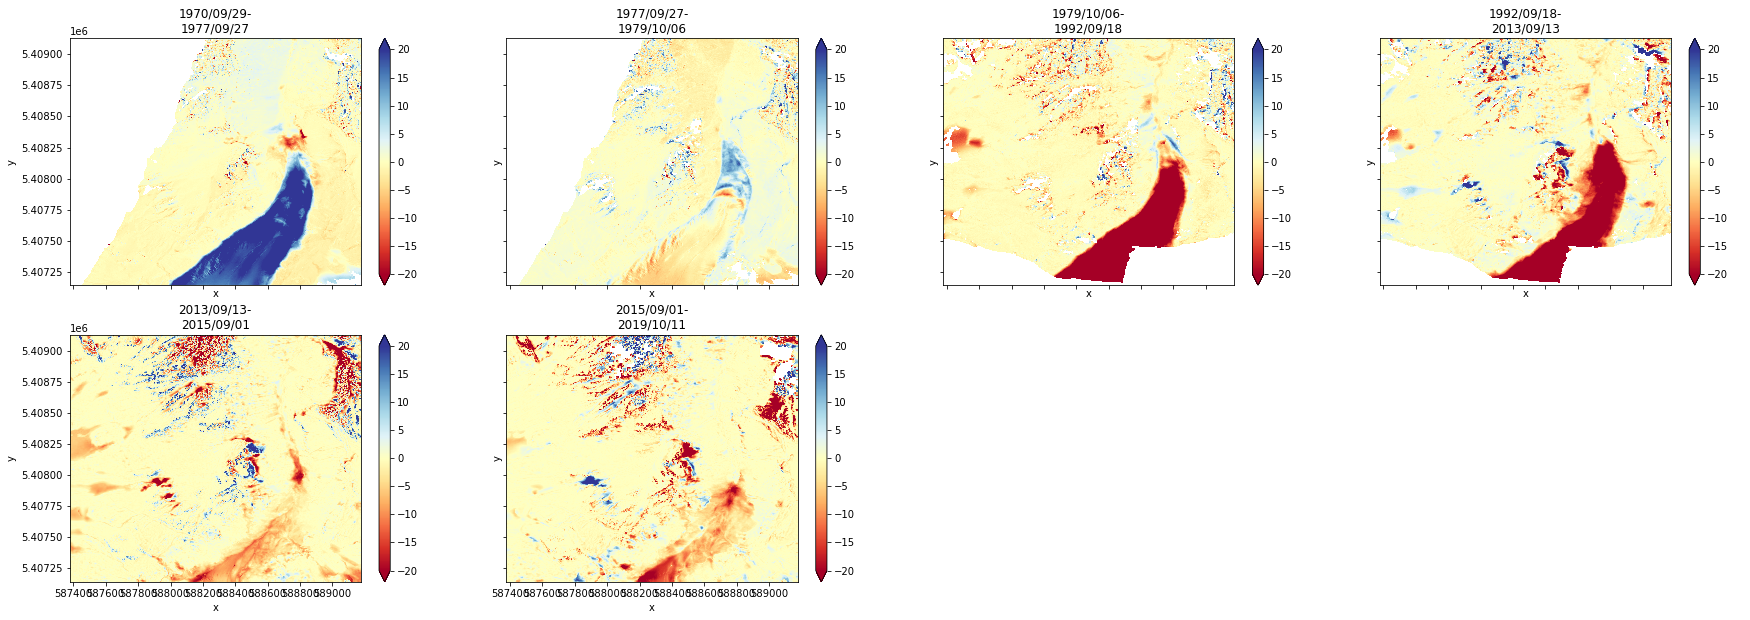

In [16]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=False
)
fig.savefig(os.path.join(plot_output_dir, "dod_gallery_preprocessing.png"))
plt.show()

## Mask Glacier Signals

In [17]:
if MASK_GLACIER_SIGNALS:
    for ddem in demcollection.ddems:
        ddem
        relevant_glaciers_gdf = glaciers_gdf[glaciers_gdf['date'].isin([ddem.interval.left, ddem.interval.right])]
        relevant_glaciers_mask = gu.Vector(relevant_glaciers_gdf).create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, relevant_glaciers_mask)

## Filter outliers

In [18]:
if FILTER_OUTLIERS:
    if SIMPLE_FILTER:
        for dh in demcollection.ddems:
            dh.data = np.ma.masked_where(np.abs(dh.data) > simple_filter_threshold, dh.data)
    else:
        for dh in demcollection.ddems:
            all_values_masked = dh.data.copy()
            all_values = all_values_masked.filled(np.nan)
            low = np.nanmedian(all_values) - 4*xdem.spatialstats.nmad(all_values)
            high = np.nanmedian(all_values) + 4*xdem.spatialstats.nmad(all_values)
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print(dh.interval)
            print(low)
            print(high)
            all_values_masked = np.ma.masked_greater(all_values_masked, high)
            all_values_masked = np.ma.masked_less(all_values_masked, low)
            dh.data = all_values_masked
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print()

## Prepare erosion polygons

### Load erosion polygons

In [19]:
erosion_vector = gu.Vector(erosion_polygon_file)
erosion_vector.ds = erosion_vector.ds.to_crs(demcollection.reference_dem.crs)
erosion_vector.ds.head(3)

id    name       type                                           geometry
0  None  Mazama    fluvial  POLYGON ((588771.169 5407951.512, 588772.451 5...
1  None    None  hillslope  POLYGON ((588918.866 5409089.848, 588943.970 5...
2  None    None  hillslope  POLYGON ((588624.786 5409398.303, 588637.677 5...

### Subtract glacier polygons from erosion polygons

Only applies if not EROSION_BY_DATE

For each dDEM time interval, get the two relevant glacier polygons, and subtract them from each erosion polygon, so that each erosion polygon multiplies to become one erosion polygon per time interval

In [20]:
if not EROSION_BY_DATE:    
    new_erosion_gdf = []

    def subtract_multiple_geoms(polygon, cutting_geometries):
            new_polygon = polygon
            for cutting_geom in cutting_geometries:
                new_polygon = new_polygon.difference(cutting_geom)
            return new_polygon

    for ddem in demcollection.ddems:
        relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
        print(f"Cropping with {len(relevant_glacier_polygons)} glacier polygons.")
        differenced_geoms = erosion_vector.ds.geometry.apply(
            lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
        )
        new_erosion_gdf.append(
            gpd.GeoDataFrame(
                {
                    'geometry': differenced_geoms,
                    'type': erosion_vector.ds['type'],
                    'interval': np.full(
                        len(differenced_geoms),
                        ddem.interval
                    )
                }
            )
        )
    ## also do it for bounding dataset
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right])]
    differenced_geoms = erosion_vector.ds.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf.append(
            gpd.GeoDataFrame(
                {
                    'geometry': differenced_geoms,
                    'type': erosion_vector.ds['type'],
                    'interval': np.full(
                        len(differenced_geoms),
                        pd.Interval(demcollection.ddems[0].interval.left, demcollection.ddems[-1].interval.right)
                    )
                }
            )
        )
    new_erosion_gdf = pd.concat(new_erosion_gdf)
    erosion_vector.ds = new_erosion_gdf

    src = new_erosion_gdf.copy()
    src['interval'] = src['interval'].apply(lambda x: x.left.strftime(strip_time_format))
    src.to_file(erosion_polygons_cropped_by_glaciers_output_file, driver='GeoJSON')

Cropping with 3 glacier polygons.
Cropping with 2 glacier polygons.
Cropping with 2 glacier polygons.
Cropping with 2 glacier polygons.
Cropping with 2 glacier polygons.
Cropping with 2 glacier polygons.


### Split erosion vector into dictionary that organizes erosion polygons by a pd.Interval(start_date, end_Date)

We do this so that DEMCollection.get_dv_series assigns the correct polygons to the correct dDEMs

In [21]:
erosion_vector.ds

geometry       type  \
0  MULTIPOLYGON (((588718.530 5408273.792, 588718...    fluvial   
1  MULTIPOLYGON (((588943.970 5409040.318, 588939...  hillslope   
2  POLYGON ((588663.460 5409414.587, 588667.530 5...  hillslope   
3  POLYGON ((588902.996 5409522.637, 588910.844 5...  hillslope   
0  POLYGON ((588692.311 5408307.334, 588685.900 5...    fluvial   
1  MULTIPOLYGON (((588948.041 5409059.316, 588943...  hillslope   
2  POLYGON ((588656.675 5409412.552, 588663.460 5...  hillslope   
3  POLYGON ((588891.526 5409522.336, 588902.996 5...  hillslope   
0  POLYGON ((588692.311 5408307.334, 588685.900 5...    fluvial   
1  MULTIPOLYGON (((588948.041 5409059.316, 588943...  hillslope   
2  POLYGON ((588656.675 5409412.552, 588663.460 5...  hillslope   
3  POLYGON ((588891.526 5409522.336, 588902.996 5...  hillslope   
0  POLYGON ((588702.569 5408286.818, 588700.005 5...    fluvial   
1  MULTIPOLYGON (((588948.041 5409059.316, 588943...  hillslope   
2  POLYGON ((588656.675 5409412.552, 588663.460 5...  hillslope   
3  POLYGON ((588891.526 5409522.336, 588902.996 5...  hillslope   
0  MULTIPOLYGON (((588732.702 5408252.197, 588723...    fluvial   
1  MULTIPOLYGON (((588948.041 5409059.316, 588943...  hillslope   
2  POLYGON ((588656.675 5409412.552, 588663.460 5...  hillslope   
3  POLYGON ((588891.526 5409522.336, 588902.996 5...  hillslope   
0  POLYGON ((588776.939 5408047.680, 588780.786 5...    fluvial   
1  MULTIPOLYGON (((588948.041 5409059.316, 588943...  hillslope   
2  POLYGON ((588656.675 5409412.552, 588663.460 5...  hillslope   
3  POLYGON ((588891.526 5409522.336, 588902.996 5...  hillslope   
0  MULTIPOLYGON (((588718.530 5408273.792, 588718...    fluvial   
1  MULTIPOLYGON (((588943.970 5409040.318, 588939...  hillslope   
2  POLYGON ((588663.460 5409414.587, 588667.530 5...  hillslope   
3  POLYGON ((588902.996 5409522.637, 588910.844 5...  hillslope   

                   interval  
0  (1970-09-29, 1977-09-27]  
1  (1970-09-29, 1977-09-27]  
2  (1970-09-29, 1977-09-27]  
3  (1970-09-29, 1977-09-27]  
0  (1977-09-27, 1979-10-06]  
1  (1977-09-27, 1979-10-06]  
2  (1977-09-27, 1979-10-06]  
3  (1977-09-27, 1979-10-06]  
0  (1979-10-06, 1992-09-18]  
1  (1979-10-06, 1992-09-18]  
2  (1979-10-06, 1992-09-18]  
3  (1979-10-06, 1992-09-18]  
0  (1992-09-18, 2013-09-13]  
1  (1992-09-18, 2013-09-13]  
2  (1992-09-18, 2013-09-13]  
3  (1992-09-18, 2013-09-13]  
0  (2013-09-13, 2015-09-01]  
1  (2013-09-13, 2015-09-01]  
2  (2013-09-13, 2015-09-01]  
3  (2013-09-13, 2015-09-01]  
0  (2015-09-01, 2019-10-11]  
1  (2015-09-01, 2019-10-11]  
2  (2015-09-01, 2019-10-11]  
3  (2015-09-01, 2019-10-11]  
0  (1970-09-29, 2019-10-11]  
1  (1970-09-29, 2019-10-11]  
2  (1970-09-29, 2019-10-11]  
3  (1970-09-29, 2019-10-11]

In [22]:
if EROSION_BY_DATE:
    # need to create a column "interval" for sorting. Columns 'start_date' and 'end_date' should be in the erosion polygons file if `EROSION_BY_DATE`
    erosion_vector.ds['interval'] = erosion_vector.ds.apply(
        lambda row: pd.Interval(
            pd.Timestamp(datetime.strptime(row['start_date'], strip_time_format)),
            pd.Timestamp(datetime.strptime(row['end_date'], strip_time_format)),
        ), 
        axis=1
    )

start_date_to_gfd = dict(list(erosion_vector.ds.groupby("interval")))
start_date_to_gfd = dict({(key, gu.Vector(gdf)) for key, gdf in start_date_to_gfd.items()})
demcollection.outlines = start_date_to_gfd

Plot erosion geoms by date

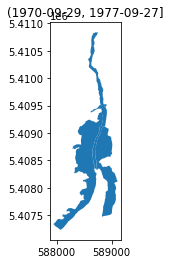

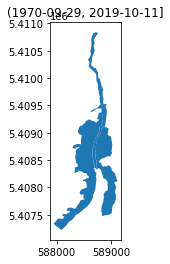

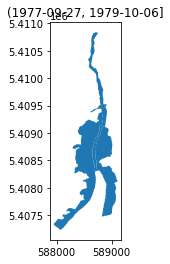

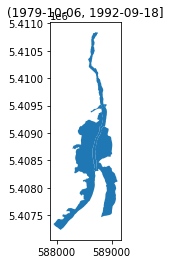

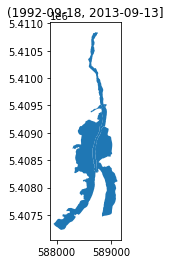

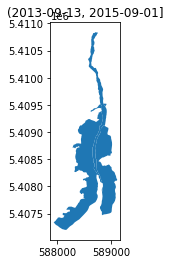

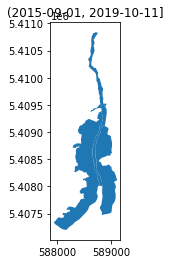

In [23]:
grouped_erosion_vector_gdf = erosion_vector.ds.groupby('interval')
for tup in list(grouped_erosion_vector_gdf):
    interval = tup[0]
    gdf = tup[1]
    gdf.plot()
    plt.gca().set_title(str(interval))
    plt.show()

## Plot DoDs

/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


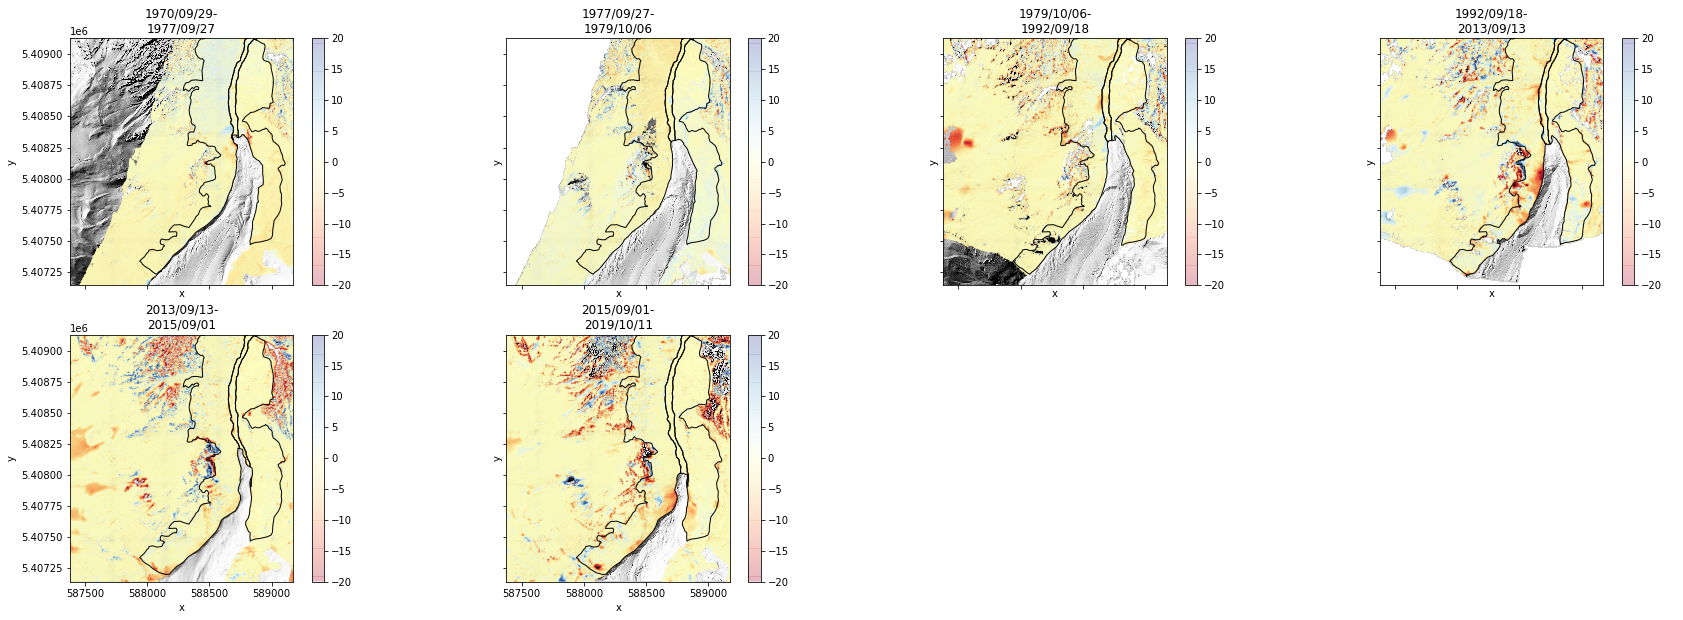

In [24]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=True,
    hillshade=True,
    cmap_alpha=0.15
)
fig.savefig(os.path.join(plot_output_dir, "dod_gallery_glaciers_masked.png"))
plt.show()

## Mask Extra Signals

In [25]:
if MASK_EXTRA_SIGNALS:
    for ddem in demcollection.ddems:
        local_erosion_vector = erosion_vector.copy()
        local_erosion_vector.ds = local_erosion_vector.ds[local_erosion_vector.ds['interval'] == ddem.interval]
        extra_signals_mask = ~local_erosion_vector.create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, extra_signals_mask)

## Plot DoDs

/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


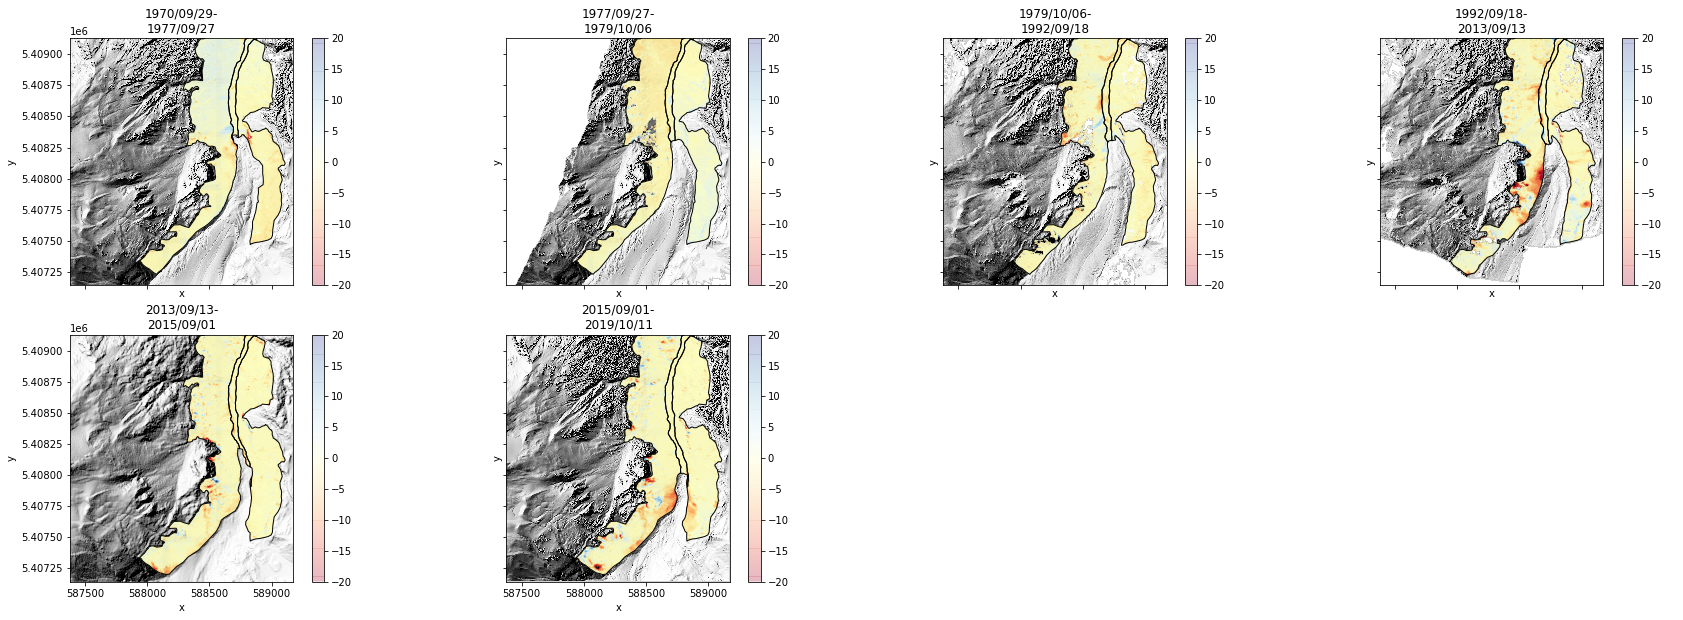

In [26]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=True,
    hillshade=True,
    cmap_alpha=0.15
)
fig.savefig(os.path.join(plot_output_dir, "dod_gallery_glaciers_and_extra_masked.png"))
plt.show()

## Interpolate

In [27]:
if INTERPOLATE:
    interpolated_ddems = demcollection.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcollection.set_ddem_filled_data()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


## Mask Extra Signals (again)

We need to do this because we may have added some pixels buffered around the erosion polygons during the interpolation

In [28]:
if MASK_EXTRA_SIGNALS:
    for ddem in demcollection.ddems:
        local_erosion_vector = erosion_vector.copy()
        local_erosion_vector.ds = local_erosion_vector.ds[local_erosion_vector.ds['interval'] == ddem.interval]
        extra_signals_mask = ~local_erosion_vector.create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, extra_signals_mask)

## Plot DoDs

/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (
/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


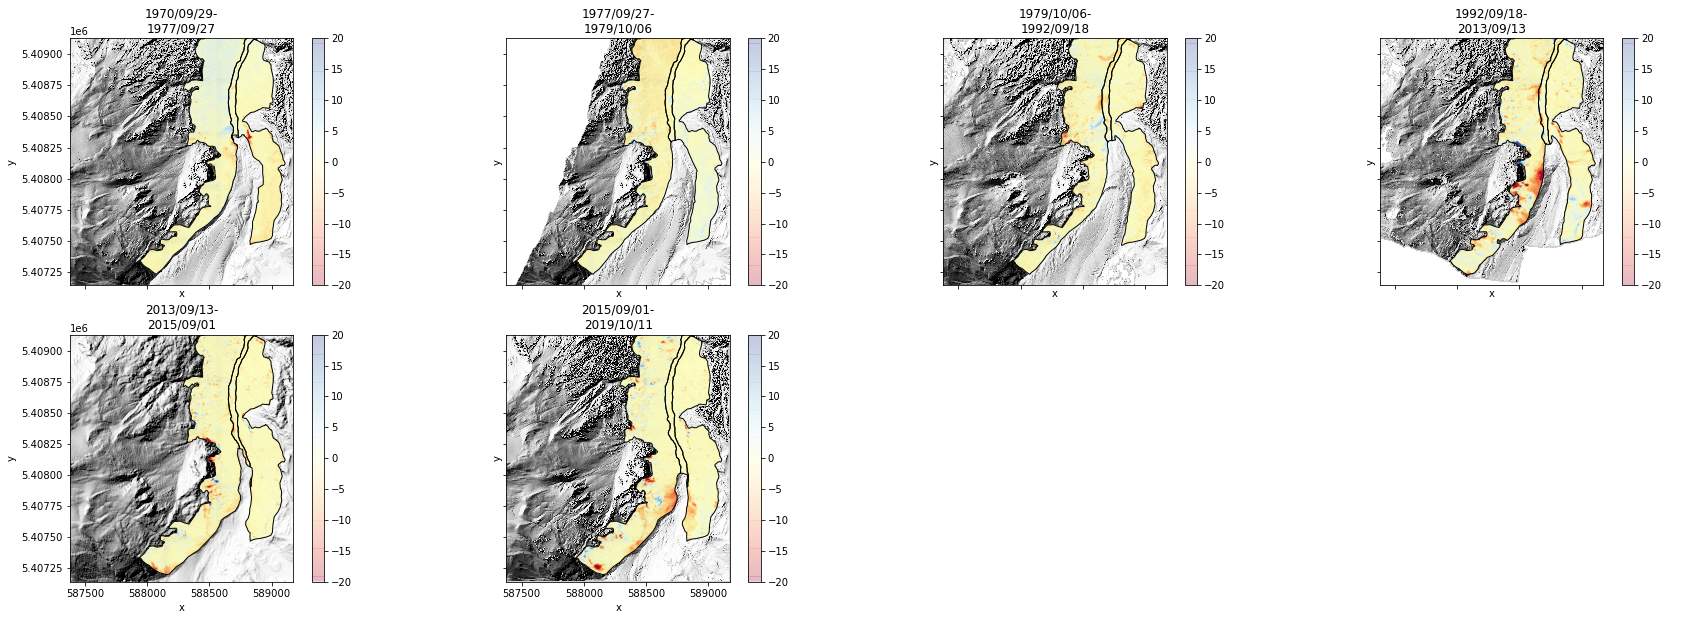

In [29]:
fig, axes = demcollection.plot_ddems(
    figsize=plot_figsize, vmin=plot_vmin, vmax=plot_vmax, 
    interpolation = "none", 
    plot_outlines=True,
    hillshade=True,
    cmap_alpha=0.15
)
fig.savefig(os.path.join(plot_output_dir, "dods_final_interpolated.png"))
plt.show()

## Plot distributions of data

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


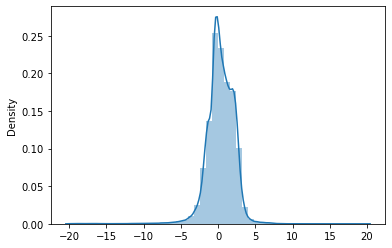

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


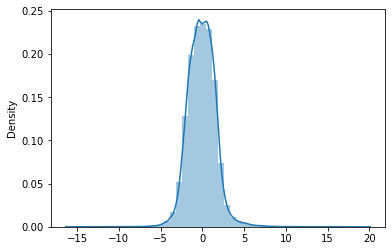

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


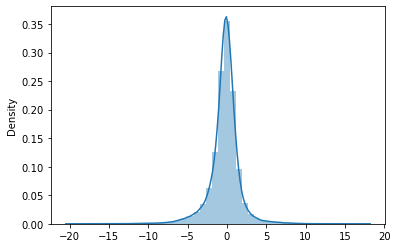

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


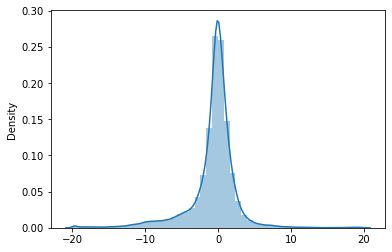

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


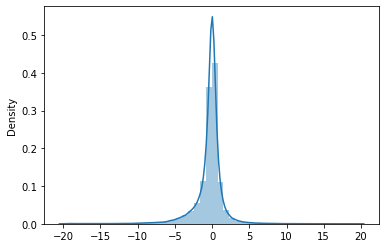

/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


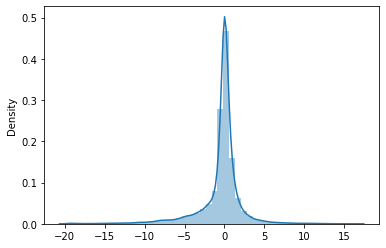

In [30]:
for ddem in demcollection.ddems:
    sns.distplot(ddem.data.filled(np.nan))
    plt.show()

##### CREATEA/CHECK OUT BOUNDIND DDEM

## Save dDEMs to tif

The datasets generated here are used to help creation of erosion polygons (and others)

In [31]:
if SAVE_DDEMS:
    # Save all interval dDEMs
    os.makedirs(dods_output_path, exist_ok=True)

    for ddem in demcollection.ddems:
        startt = ddem.start_time.strftime(strip_time_format)
        endt = ddem.end_time.strftime(strip_time_format)
        if RUN_LARGER_AREA:
            fn = f"{startt}_to_{endt}_largerarea.tif"
        else:
            fn = f"{startt}_to_{endt}.tif"
        fn = os.path.join(dods_output_path, fn)
        print(fn)
        ddem_xr = ddem.to_xarray()
        ddem_xr.data = ddem.data.filled(np.nan)
        ddem_xr.rio.to_raster(fn)

    # Save bounding dDEM

    bounding_ddem = xdem.dDEM(  
        demcollection.dems[-1] - demcollection.dems[0],
        demcollection.timestamps[0], 
        demcollection.timestamps[-1]
    )
    filled_data = bounding_ddem.interpolate(
        method="linear", 
        reference_elevation=demcollection.reference_dem, 
        max_search_distance=interpolation_max_search_distance
    )
    bounding_ddem.set_filled_data()

    # Mask out areas that are not within erosion vector. 
    # We only want to include areas that are within the erosion vectors for both dates.
    # We want to mask out areas that are not in the erosion polygons for the start date and not in the erosion polygons for the end date
    local_erosion_vector = erosion_vector.copy()
    #grab erosion polygons associated with the bounding interval 
    local_erosion_vector.ds = local_erosion_vector.ds[local_erosion_vector.ds['interval'] == bounding_ddem.interval]
    signal_we_want_mask = local_erosion_vector.create_mask(bounding_ddem).squeeze()
    bounding_ddem.data.mask = ~signal_we_want_mask
    bounding_ddem_xr = bounding_ddem.to_xarray()
    bounding_ddem_xr.data = bounding_ddem.data.filled(np.nan)
    startt = pd.Timestamp(bounding_ddem.start_time).strftime(strip_time_format)
    endt = pd.Timestamp(bounding_ddem.end_time).strftime(strip_time_format)
    if RUN_LARGER_AREA:
        fn = f"{startt}_to_{endt}_largerarea.tif"
    else:
        fn = f"{startt}_to_{endt}.tif"
    fn = os.path.join(dods_output_path, fn)
    print(fn)
    # bounding_ddem_copy = bounding_ddem.copy()
    bounding_ddem_xr.rio.to_raster(fn)

/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/1970_09_29_to_1977_09_27.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/1977_09_27_to_1979_10_06.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/1979_10_06_to_1992_09_18.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/1992_09_18_to_2013_09_13.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/2013_09_13_to_2015_09_01.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/2015_09_01_to_2019_10_11.tif
/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dods/1970_09_29_to_2019_10_11.tif


## Mass wasting calculations

### Calculate net mass wasted

In [32]:
dv_df = demcollection.get_dv_series(return_area=True).reset_index()
dv_df.head()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


index        dh      area         volume
0  (1970-09-29, 1977-09-27]  0.342562  806992.0  276445.170256
1  (1977-09-27, 1979-10-06] -0.050455  809352.0  -40836.072449
2  (1979-10-06, 1992-09-18] -0.300567  804020.0 -241661.976075
3  (1992-09-18, 2013-09-13] -0.668323  830940.0 -555335.965912
4  (2013-09-13, 2015-09-01] -0.358174  976160.0 -349635.023494

### Calculate net mass wasted by erosion type

In [33]:
hillslope_dv_df = demcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_dv_df['type'] = 'hillslope'
fluvial_dv_df = demcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate net mass wasted with threshold (1 meter)

In [34]:
def threshold_ddem(ddem, threshold):
    ddem = ddem.copy()
    ddem.data = np.ma.masked_where(np.abs(ddem.data) < measurement_threshold, ddem.data)
    return ddem

threshold_ddems = [threshold_ddem(ddem, 1) for ddem in demcollection.ddems]

threshold_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
threshold_ddemcollection.ddems_are_intervalwise = True
threshold_ddemcollection.ddems = threshold_ddems
threshold_ddemcollection.outlines = demcollection.outlines

In [35]:
threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True).reset_index()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


/home/elilouis/xdem/xdem/demcollection.py:278: UserWarning: NaNs found in dDEM (1970-09-29 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:278: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:278: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 1992-09-18 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:278: UserWarning: NaNs found in dDEM (1992-09-18 00:00:00 - 2013-09-13 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:278: UserWarning: NaNs found in dDEM (2013-09-13 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_

### Calculate net mass wasted with threshold (1 meter), by erosion type

In [36]:
hillslope_threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_threshold_dv_df['type'] = 'hillslope'
fluvial_threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_threshold_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted

In [37]:
def create_positive_and_negative_ddems(ddem):
    pos = ddem.copy()
    neg = ddem.copy()
    pos.data = np.ma.masked_less(pos.data, 0)
    neg.data = np.ma.masked_greater(neg.data, 0)
    return pos, neg

pos_ddems, neg_ddems = zip(*[create_positive_and_negative_ddems(ddem) for ddem in demcollection.ddems])
pos_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
pos_ddemcollection.ddems_are_intervalwise = True
pos_ddemcollection.ddems = pos_ddems
pos_ddemcollection.outlines = demcollection.outlines

neg_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
neg_ddemcollection.ddems_are_intervalwise = True
neg_ddemcollection.ddems = neg_ddems
neg_ddemcollection.outlines = demcollection.outlines

In [38]:
pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True).reset_index()
neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True).reset_index()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted, by erosion type

In [39]:
hillslope_pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_pos_dv_df['type'] = 'hillslope'

fluvial_pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_pos_dv_df['type'] = 'fluvial'

hillslope_neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_neg_dv_df['type'] = 'hillslope'

fluvial_neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_neg_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted with threshold (1 meter)

In [40]:
threshold_pos_ddemcollection = xdem.DEMCollection(
    pos_ddemcollection.dems,
    pos_ddemcollection.timestamps
)
threshold_pos_ddemcollection.ddems_are_intervalwise = True
threshold_pos_ddemcollection.ddems = [threshold_ddem(ddem, 1) for ddem in pos_ddemcollection.ddems]
threshold_pos_ddemcollection.outlines = pos_ddemcollection.outlines



threshold_neg_ddemcollection = xdem.DEMCollection(
    neg_ddemcollection.dems,
    neg_ddemcollection.timestamps
)
threshold_neg_ddemcollection.ddems_are_intervalwise = True
threshold_neg_ddemcollection.ddems = [threshold_ddem(ddem, 1) for ddem in neg_ddemcollection.ddems]
threshold_neg_ddemcollection.outlines = neg_ddemcollection.outlines

In [41]:
threshold_pos_dv_df = threshold_pos_ddemcollection.get_dv_series(return_area=True).reset_index()
threshold_neg_dv_df = threshold_neg_ddemcollection.get_dv_series(return_area=True).reset_index()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted with threshold (1 meter), by erosion type

In [42]:
hillslope_threshold_pos_dv_df = threshold_pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_threshold_pos_dv_df['type'] = 'hillslope'

fluvial_threshold_pos_dv_df = threshold_pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_threshold_pos_dv_df['type'] = 'fluvial'

hillslope_threshold_neg_dv_df = threshold_neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_threshold_neg_dv_df['type'] = 'hillslope'

fluvial_threshold_neg_dv_df = threshold_neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_threshold_neg_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Add metadata to all the dataframes resulting from the calculations

Maybe this should be added as functionality to DEMCollection?

In [43]:
def enrich_volume_data(df, pixel_area, pixel_side_length, uncertainty_df):
    """Modify the resulting dataframe of `demcollection.get_dv_series` by 
    adding a bunch of useful data. Calculates volumetric uncertainty as well.

    Args:
        df (_type_): _description_
        pixel_area (_type_): _description_
    """
    df["n_pixels"] = df["area"]/pixel_area

    df["volumetric_uncertainty"] = df.apply(
        lambda row: xdem.spatialstats.volumetric_uncertainty(
            n_pixels = row["n_pixels"],
            pixel_side_length = pixel_side_length,
            rmse = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['RMSE'].iloc[0],
            mean = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Mean'].iloc[0],
            range_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Range'].iloc[0],
            sill_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Sill'].iloc[0],
        ),
        axis=1
    )
    df['start_time'] = df['index'].apply(lambda x: x.left)
    df['end_time'] = df['index'].apply(lambda x: x.right)
    df['time_difference_years'] = df.apply(
        lambda row: round((row['end_time'] - row['start_time']).days/365.25),
        axis=1
    )
    df['Annual Mass Wasted'] = df['volume']/df['time_difference_years']
    df["Upper CI"] = (df['volume'] + df['volumetric_uncertainty'])/df['time_difference_years']
    df["Lower CI"] = (df['volume'] - df['volumetric_uncertainty'])/df['time_difference_years']
    df["Average Date"] = df['start_time'] + ((df['end_time'] - df['start_time']) / 2).dt.ceil('D')
    return df

In [44]:
dv_df = enrich_volume_data(
    dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

fluvial_dv_df = enrich_volume_data(
    fluvial_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_dv_df = enrich_volume_data(
    hillslope_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

threshold_dv_df = enrich_volume_data(
    threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_threshold_dv_df = enrich_volume_data(
    hillslope_threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

fluvial_threshold_dv_df = enrich_volume_data(
    fluvial_threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)


pos_dv_df = enrich_volume_data(
    pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

neg_dv_df = enrich_volume_data(
    neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_pos_dv_df = enrich_volume_data(
    hillslope_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
fluvial_pos_dv_df = enrich_volume_data(
    fluvial_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
hillslope_neg_dv_df = enrich_volume_data(
    hillslope_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
fluvial_neg_dv_df = enrich_volume_data(
    fluvial_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

threshold_pos_dv_df = enrich_volume_data(
    threshold_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)
threshold_neg_dv_df = enrich_volume_data(
    threshold_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)
hillslope_threshold_pos_dv_df = enrich_volume_data(
    hillslope_threshold_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)
fluvial_threshold_pos_dv_df = enrich_volume_data(
    fluvial_threshold_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)
hillslope_threshold_neg_dv_df = enrich_volume_data(
    hillslope_threshold_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)
fluvial_threshold_neg_dv_df = enrich_volume_data(
    fluvial_threshold_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0],
    uncertainty_df = uncertainty_df
)

### Plot

#### Plot net mass wasted

In [45]:
bars = alt.Chart(dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars = alt.Chart(dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

chart

alt.LayerChart(...)

In [54]:
cum_dv_df = dv_df.copy()
cum_dv_df['cumulative volume'] = dv_df['volume'].cumsum()
cum_dv_df['Lower CI'] = 0
cum_dv_df['Upper CI'] = 0
cum_dv_df.loc[len(cum_dv_df) - 1, 'Lower CI'] = cum_dv_df.loc[len(cum_dv_df) - 1, 'cumulative volume'] - np.sqrt(
    (cum_dv_df['volumetric_uncertainty']**2).sum()
)
cum_dv_df.loc[len(cum_dv_df) - 1, 'Upper CI'] = cum_dv_df.loc[len(cum_dv_df) - 1, 'cumulative volume'] + np.sqrt(
    (cum_dv_df['volumetric_uncertainty']**2).sum()
)
cum_dv_df = cum_dv_df.append({
        'cumulative volume': 0,
        'end_time': cum_dv_df.iloc[0]['start_time'],
        'volumetric_uncertainty': 0
    }, ignore_index=True
)
cum_dv_df['end_time'] = cum_dv_df['end_time'].apply(pd.Timestamp)
cum_dv_df.head(2)

index        dh      area         volume  n_pixels  \
0  (1970-09-29, 1977-09-27]  0.342562  806992.0  276445.170256  201748.0   
1  (1977-09-27, 1979-10-06] -0.050455  809352.0  -40836.072449  202338.0   

   volumetric_uncertainty start_time   end_time  time_difference_years  \
0           202997.762219 1970-09-29 1977-09-27                    7.0   
1           244297.189132 1977-09-27 1979-10-06                    2.0   

   Annual Mass Wasted  Upper CI  Lower CI Average Date  cumulative volume  
0        39492.167179       0.0       0.0   1974-03-30      276445.170256  
1       -20418.036224       0.0       0.0   1978-10-02      235609.097807

In [57]:
cum_dv_df

index        dh      area         volume  n_pixels  \
0  (1970-09-29, 1977-09-27]  0.342562  806992.0  276445.170256  201748.0   
1  (1977-09-27, 1979-10-06] -0.050455  809352.0  -40836.072449  202338.0   
2  (1979-10-06, 1992-09-18] -0.300567  804020.0 -241661.976075  201005.0   
3  (1992-09-18, 2013-09-13] -0.668323  830940.0 -555335.965912  207735.0   
4  (2013-09-13, 2015-09-01] -0.358174  976160.0 -349635.023494  244040.0   
5  (2015-09-01, 2019-10-11] -0.439103  988812.0 -434190.681021  247203.0   
6                       NaN       NaN       NaN            NaN       NaN   

   volumetric_uncertainty start_time   end_time  time_difference_years  \
0           202997.762219 1970-09-29 1977-09-27                    7.0   
1           244297.189132 1977-09-27 1979-10-06                    2.0   
2           237292.290292 1979-10-06 1992-09-18                   13.0   
3           194495.654479 1992-09-18 2013-09-13                   21.0   
4            40401.920954 2013-09-13 2015-09-01                    2.0   
5            64666.475645 2015-09-01 2019-10-11                    4.0   
6                0.000000        NaT 1970-09-29                    NaN   

   Annual Mass Wasted       Upper CI      Lower CI Average Date  \
0        39492.167179       0.000000  0.000000e+00   1974-03-30   
1       -20418.036224       0.000000  0.000000e+00   1978-10-02   
2       -18589.382775       0.000000  0.000000e+00   1986-03-29   
3       -26444.569805       0.000000  0.000000e+00   2003-03-18   
4      -174817.511747       0.000000  0.000000e+00   2014-09-07   
5      -108547.670255 -897063.383333 -1.793366e+06   2017-09-21   
6                 NaN            NaN           NaN          NaT   

   cumulative volume  
0       2.764452e+05  
1       2.356091e+05  
2      -6.052878e+03  
3      -5.613888e+05  
4      -9.110239e+05  
5      -1.345215e+06  
6       0.000000e+00

In [68]:
cum_plot = alt.Chart(cum_dv_df.drop(columns='index')).mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', title='Cumulative volume wasted (m^3)')
)

error_bars = alt.Chart(cum_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

(error_bars + cum_plot).properties(height=200)

alt.LayerChart(...)

#### Plot cumulative net mass wasted

#### Plot net mass wasted by erosion type

In [ ]:
bars = alt.Chart(fluvial_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(fluvial_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

fluvial_chart = bars + error_bars

bars = alt.Chart(hillslope_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(hillslope_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

hillslope_chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

(fluvial_chart.properties(title='fluvial') & hillslope_chart.properties(title='hillslope')).resolve_scale(x='shared')

In [ ]:
hillslope_dv_df

#### Plot net mass wasted, thresholded

In [ ]:
bars = alt.Chart(threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars = alt.Chart(threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

chart

#### Plot net mass wasted by erosion type, thresholded

In [ ]:
bars = alt.Chart(fluvial_threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(fluvial_threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

fluvial_chart = bars + error_bars

bars = alt.Chart(hillslope_threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(hillslope_threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

hillslope_chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

(fluvial_chart.properties(title='fluvial') & hillslope_chart.properties(title='hillslope')).resolve_scale(x='shared')

#### Plot gross positive and negative mass wasted

In [ ]:
bars_neg = alt.Chart(neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = (bars_pos + error_bars_pos + bars_neg + error_bars_neg)
# chart.save(os.path.join(plot_output_dir, "mass_wasted_gross.png"), scale_factor=2.0)
chart

####  Plot gross positive and negative mass wasted, thresholded

In [ ]:
bars_neg = alt.Chart(threshold_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(threshold_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(threshold_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(threshold_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = (bars_pos + error_bars_pos + bars_neg + error_bars_neg)
# chart.save(os.path.join(plot_output_dir, "mass_wasted_gross.png"), scale_factor=2.0)
chart

#### Plot gross positive and negative mass wasted, by erosion type

In [ ]:
bars_neg = alt.Chart(fluvial_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(fluvial_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(fluvial_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(fluvial_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_fluvial = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='fluvial')

In [ ]:
bars_neg = alt.Chart(hillslope_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(hillslope_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(hillslope_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(hillslope_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_hillslope = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='hillslope')

In [ ]:
chart_fluvial & chart_hillslope

#### Plot  gros positive and negative mass wasted by erosion type, thresholded

In [ ]:
bars_neg = alt.Chart(fluvial_threshold_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(fluvial_threshold_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(fluvial_threshold_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(fluvial_threshold_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_fluvial = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='fluvial')

In [ ]:
bars_neg = alt.Chart(hillslope_threshold_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(hillslope_threshold_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(hillslope_threshold_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 1.5,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(hillslope_threshold_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_hillslope = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='hillslope')

In [ ]:
chart_fluvial & chart_hillslope